# Data preparation

In [362]:
import pandas as pd

FILE_ID = "1tedl9Ge1NfqXeT58hLbauNX5StYOlLAoc9H20M5OlNI" 
GID = "1104856451" 
url = f"https://docs.google.com/spreadsheets/d/{FILE_ID}/export?format=csv&gid={GID}"

df = pd.read_csv(url, dtype=str) 
df.head()


,product_id,product_name,category,category 1,category 2,category 3,category 4,category 5,category 6,category 7,...,product_link,review_marker,full_text,pos_hits,neg_hits,neg_ratio,text_marker,Red_flag,Red_flag_key_word,Red_flag_category
0,B07JW9H4J1,Wayona Nylon Braided USB to Lightning Fast Cha...,Computers&Accessories|Accessories&Peripherals|...,Computers&Accessories,Accessories&Peripherals,Cables&Accessories,Cables,USBCables,NaN,NaN,...,https://www.amazon.in/Wayona-Braided-WN3LG1-Sy...,good,"Satisfied,Charging is really fast,Value for mo...",39,14,0.26,title_unclear,red_flag,replacement,servise
1,B098NS6PVG,Ambrane Unbreakable 60W / 3A Fast Charging 1.5...,Computers&Accessories|Accessories&Peripherals|...,Computers&Accessories,Accessories&Peripherals,Cables&Accessories,Cables,USBCables,NaN,NaN,...,https://www.amazon.in/Ambrane-Unbreakable-Char...,good,"A Good Braided Cable for Your Type C Device,Go...",63,22,0.26,title_unclear,red_flag,replacement,servise
2,B096MSW6CT,Sounce Fast Phone Charging Cable & Data Sync U...,Computers&Accessories|Accessories&Peripherals|...,Computers&Accessories,Accessories&Peripherals,Cables&Accessories,Cables,USBCables,NaN,NaN,...,https://www.amazon.in/Sounce-iPhone-Charging-C...,neutral,"Good speed for earlier versions,Good Product,W...",23,7,0.23,title_positive,NaN,NaN,NaN
3,B08HDJ86NZ,boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...,Computers&Accessories|Accessories&Peripherals|...,Computers&Accessories,Accessories&Peripherals,Cables&Accessories,Cables,USBCables,NaN,NaN,...,https://www.amazon.in/Deuce-300-Resistant-Tang...,good,"Good product,Good one,Nice,Really nice product...",44,8,0.15,title_positive,red_flag,stopped working,quality
4,B08CF3B7N1,Portronics Konnect L 1.2M Fast Charging 3A 8 P...,Computers&Accessories|Accessories&Peripherals|...,Computers&Accessories,Accessories&Peripherals,Cables&Accessories,Cables,USBCables,NaN,NaN,...,https://www.amazon.in/Portronics-Konnect-POR-1...,good,"As good as original,Decent,Good one for second...",102,34,0.25,title_positive,red_flag,"damaged, stopped working, stop working",quality


In [385]:
import re
def to_num(s):
    if pd.isna(s): 
        return pd.NA
    s = str(s)
    s = re.sub(r'(?<=\d),(?=\d)', '.', s)
    s = re.sub(r'[^0-9\.\-]+', '', s)
    return pd.to_numeric(s, errors='coerce')

In [364]:
num_cols = ['discounted_price','actual_price','discount_percentage','rating', 'rating_count','pos_hits', 'neg_hits', 'neg_ratio']
for c in num_cols:
    df[c] = df[c].apply(to_num)


In [365]:

df['rating_count'] = (df['rating_count'].astype(str).str.replace(',', '').str.extract(r'(\d+)').astype('Int64'))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1465 entries, 0 to 1464
Data columns (total 32 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   product_id           1465 non-null   object 
 1   product_name         1465 non-null   object 
 2   category             1465 non-null   object 
 3   category 1           1465 non-null   object 
 4   category 2           1465 non-null   object 
 5   category 3           1457 non-null   object 
 6   category 4           1300 non-null   object 
 7   category 5           522 non-null    object 
 8   category 6           85 non-null     object 
 9   category 7           13 non-null     object 
 10  discounted_price     1460 non-null   float64
 11  actual_price         1463 non-null   float64
 12  discount_percentage  1465 non-null   int64  
 13  rating               1464 non-null   float64
 14  rating_count         1463 non-null   Int64  
 15  about_product        1465 non-null   o

In [366]:
df.iloc[:, 20:30].dtypes


review_content     object
img_link           object
product_link       object
review_marker      object
full_text          object
pos_hits            int64
neg_hits            int64
neg_ratio         float64
text_marker        object
Red_flag           object
dtype: object

In [367]:

import numpy as np
import matplotlib.pyplot as plt

df = df.copy()
rf_col = 'Red_flag' if 'Red_flag' in df.columns else 'red_flag'
df['red_flag_num'] = (df[rf_col].astype(str).str.lower() == 'red_flag').astype(int)

cat1 = 'category 1' if 'category 1' in df.columns else ('category' if 'category' in df.columns else None)
cat2 = 'category 2' if 'category 2' in df.columns else None

def pct(s): 
    return 100 * s.mean()


## Subcategories (rating >=4) with highest % red flags
### Shows us the subcategories that businesses should pay attention to

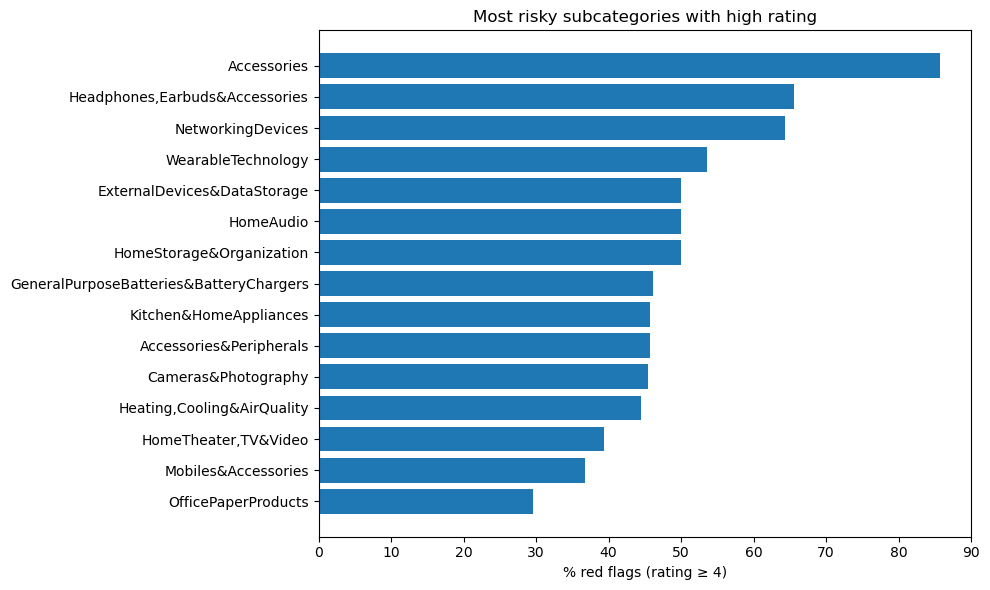

In [368]:
f = df[(df['rating']>=4) & df[cat2].notna()].copy()
top = (f.groupby(df[cat2])
         .agg(n=('product_id','nunique'),
              pct_red=('red_flag_num', pct))
         .query('n>=10')
         .sort_values('pct_red', ascending=False)
         .head(20))

plt.figure(figsize=(10,6))
plt.barh(top.index[::-1], top['pct_red'][::-1])
plt.xlabel('% red flags (rating ≥ 4)')
plt.title('Most risky subcategories with high rating')
plt.tight_layout()
plt.show()


## Heatmap: category 1 x single red-flag category (split+explode)
### Shows businesses which types of red flags are prevalent in each subcategory

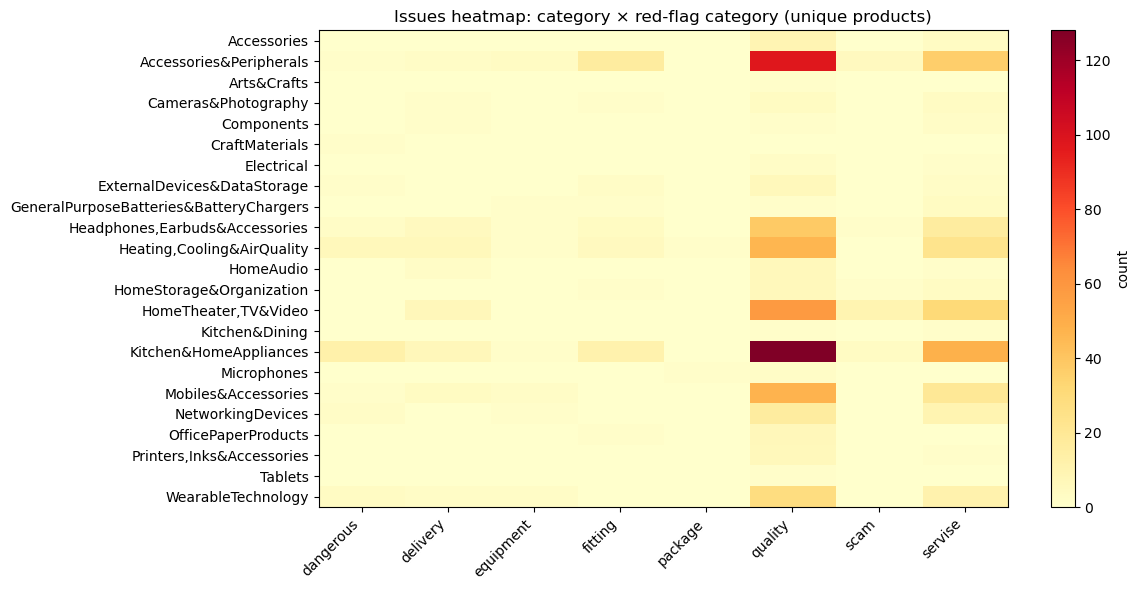

In [369]:
cat_col = 'Red_flag_category'
cat_main = cat2

tmp = df[(df['red_flag_num']==1) & df[cat_col].notna()].copy()

tmp['issue_list'] = (tmp[cat_col].astype(str)
                                   .str.lower()
                                   .str.split(','))

long = (tmp.loc[:, [cat_main, 'product_id', 'issue_list']]
           .explode('issue_list')
           .assign(issue=lambda d: d['issue_list'].str.strip())
           .drop(columns='issue_list'))

long = long[(long['issue']!='') & long['issue'].notna()]
long = long.drop_duplicates(subset=[cat_main, 'product_id', 'issue'])

pvt = (long
       .pivot_table(index=cat_main, columns='issue', values='product_id',
                    aggfunc='nunique', fill_value=0)
       .sort_index())

import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.imshow(pvt.values, aspect='auto', cmap='YlOrRd')
plt.colorbar(label='count')
plt.yticks(range(len(pvt.index)), pvt.index)
plt.xticks(range(len(pvt.columns)), pvt.columns, rotation=45, ha='right')
plt.title('Issues heatmap: category × red-flag category (unique products)')
plt.tight_layout()
plt.show()



# Prediction: Will the review be red-flagged and how will it be marked?

In [ ]:
# ==== Hackathon: Red Flag (binary) + Multi-Label Categories ====
# What we do:
# 1) Load data from your Google Sheet
# 2) Build text = review_title + review_content
# 3) Binary model: has red flag? (0/1)  -- labels from Red_flag == "red_flag"
# 4) Multi-label model: which categories? (split "Red_flag_category" by comma)
# 5) Evaluate and provide a simple predict() function

import pandas as pd
import numpy as np
import re

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    f1_score, precision_score, recall_score
)

RANDOM_STATE = 42

# Use these exact columns from the sheet
TEXT_COLS = ["review_title", "review_content"]
FLAG_COL  = "Red_flag"
CAT_COL   = "Red_flag_category"

for c in TEXT_COLS + [FLAG_COL, CAT_COL]:
    if c not in df.columns:
        raise ValueError(f"Column '{c}' not found. Available: {list(df.columns)}")

# 2) Clean + build text
def clean_text(s: str) -> str:
    s = str(s).lower()
    s = re.sub(r"[^a-zа-я0-9\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

df["text"] = df[TEXT_COLS].astype(str).agg(" ".join, axis=1).map(clean_text)
df = df[df["text"].str.len() > 0].copy()

# 3) Binary labels from Red_flag
#    IMPORTANT: only token "red_flag" is True

TRUE_TOKENS = {"red_flag"}  # <-- per your request

def to_bool_redflag(x):
    if pd.isna(x): 
        return 0
    s = str(x).strip().lower()
    return 1 if s in TRUE_TOKENS else 0

df["y_bin"] = df[FLAG_COL].map(to_bool_redflag).astype(int)

pos, neg = int(df["y_bin"].sum()), int((1 - df["y_bin"]).sum())
print(f"[Binary] label counts -> positives={pos}, negatives={neg}")

# 4) Train binary model (if both classes exist)
bin_model = None
if pos >= 3 and neg >= 3:
    Xb = df["text"]
    yb = df["y_bin"]

    # Simple split (stratified because two classes exist)
    Xb_tr, Xb_te, yb_tr, yb_te = train_test_split(
        Xb, yb, test_size=0.2, random_state=RANDOM_STATE, stratify=yb
    )

    # Dynamic min_df for small corpora
    min_df_bin = 1 if len(Xb_tr) < 200 else 2

    bin_model = Pipeline([
        ("tfidf", TfidfVectorizer(max_features=3000, ngram_range=(1,2), min_df=min_df_bin)),
        ("clf",   LogisticRegression(max_iter=1000, class_weight="balanced", random_state=RANDOM_STATE)),
    ])
    bin_model.fit(Xb_tr, yb_tr)

    yb_pred = bin_model.predict(Xb_te)
    print("\n=== Binary model: has red flag (0/1) ===")
    print(classification_report(yb_te, yb_pred, digits=3))
    print("Confusion matrix:\n", confusion_matrix(yb_te, yb_pred))
else:
    print("\n[Info] Binary model skipped (not enough samples in both classes).")

# 5) Build multi-label targets from Red_flag_category
#    Split by comma. Example: "quality, servise" -> ["quality","servise"]
def split_labels(cell):
    if pd.isna(cell):
        return []
    # split by "," and strip spaces
    parts = [p.strip().lower() for p in str(cell).split(",")]
    # drop empty tokens
    parts = [p for p in parts if p]
    return parts

df["y_list"] = df[CAT_COL].map(split_labels)

# Keep rows that have at least 1 category label
df_ml = df[df["y_list"].map(len) > 0].copy()
print(f"\n[Multi-label] rows with >=1 category: {len(df_ml)}")

# If too few rows, skip
ml_model = None
mlb = None
if len(df_ml) >= 10:
    # Binarize labels
    mlb = MultiLabelBinarizer()
    Y = mlb.fit_transform(df_ml["y_list"])
    X = df_ml["text"]

    # Quick stats
    label_counts = Y.sum(axis=0).A1 if hasattr(Y, "A1") else Y.sum(axis=0)
    counts_by_label = dict(zip(mlb.classes_, label_counts))
    print("[Multi-label] label counts (top 15):", dict(list(sorted(counts_by_label.items(), key=lambda x: -x[1]))[:15]))

    # If there is at least 1 positive label overall
    if int(label_counts.sum()) > 0 and len(mlb.classes_) >= 2:
        # Simple split (no stratify for multi-label)
        X_tr, X_te, Y_tr, Y_te = train_test_split(
            X, Y, test_size=0.2, random_state=RANDOM_STATE, shuffle=True
        )

        min_df_cat = 1 if len(X_tr) < 200 else 2

        ml_model = Pipeline([
            ("tfidf", TfidfVectorizer(max_features=4000, ngram_range=(1,2), min_df=min_df_cat)),
            ("clf",   OneVsRestClassifier(
                LogisticRegression(max_iter=1000, class_weight="balanced", random_state=RANDOM_STATE)
            )),
        ])
        ml_model.fit(X_tr, Y_tr)

        # Evaluate (micro/macro F1)
        Y_pred = ml_model.predict(X_te)
        micro_f1 = f1_score(Y_te, Y_pred, average="micro", zero_division=0)
        macro_f1 = f1_score(Y_te, Y_pred, average="macro", zero_division=0)
        micro_p  = precision_score(Y_te, Y_pred, average="micro", zero_division=0)
        micro_r  = recall_score(Y_te, Y_pred, average="micro", zero_division=0)

        print("\n=== Multi-label model: categories (One-vs-Rest) ===")
        print(f"Micro F1:  {micro_f1:.3f}   (good for overall performance)")
        print(f"Macro F1:  {macro_f1:.3f}   (average over labels)")
        print(f"Micro P/R: P={micro_p:.3f}, R={micro_r:.3f}")
        # Optional: show per-label report (short)
        # (Full classification_report for multilabel is less readable.)
    else:
        print("[Info] Multi-label model skipped (not enough positive labels or only one class).")
else:
    print("[Info] Multi-label model skipped (too few rows with categories).")

# 6) Unified predict function
#  drop-in replacement for predict_review 

def predict_review(review_title: str,
                   review_content: str,
                   threshold: float = 0.5,
                   top_k: int = 3,
                   mode: str = "threshold"):
    """
    mode:
      - "threshold": return all labels with prob >= threshold (0..1).
      - "topk":      return exactly top_k labels by prob (no threshold).
    """
    full_text = f"{review_title or ''} {review_content or ''}".strip()
    full_text = clean_text(full_text)

    # Binary prediction
    has_flag = False
    p_bin = None
    if bin_model is not None:
        p_bin = float(bin_model.predict_proba([full_text])[0][1])
        has_flag = bool(p_bin >= 0.5)

    # Multi-label prediction
    selected = []
    if ml_model is not None and mlb is not None:
        probs = ml_model.predict_proba([full_text])[0]  # shape: (n_labels,)
        cat_probs = list(zip(mlb.classes_, probs))
        cat_probs.sort(key=lambda x: -x[1])  # high to low

        if mode == "threshold":
            # all labels that pass the threshold
            selected = [(lab, float(p)) for lab, p in cat_probs if p >= threshold]
            # if none pass, fall back to top_k (optional but handy)
            if len(selected) == 0:
                selected = [(lab, float(p)) for lab, p in cat_probs[:top_k]]
        elif mode == "topk":
            selected = [(lab, float(p)) for lab, p in cat_probs[:top_k]]
        else:
            raise ValueError("mode must be 'threshold' or 'topk'")

    return {
        "has_red_flag": has_flag,
        "red_flag_prob": p_bin,
        "categories": selected
    }



[Binary] label counts -> positives=708, negatives=757

=== Binary model: has red flag (0/1) ===
              precision    recall  f1-score   support

           0      0.778     0.788     0.783       151
           1      0.771     0.761     0.766       142

    accuracy                          0.775       293
   macro avg      0.775     0.774     0.774       293
weighted avg      0.775     0.775     0.775       293

Confusion matrix:
 [[119  32]
 [ 34 108]]

[Multi-label] rows with >=1 category: 708
[Multi-label] label counts (top 15): {'quality': 555, 'servise': 233, 'fitting': 45, 'delivery': 38, 'dangerous': 32, 'scam': 22, 'equipment': 13, 'package': 2}

=== Multi-label model: categories (One-vs-Rest) ===
Micro F1:  0.770   (good for overall performance)
Macro F1:  0.393   (average over labels)
Micro P/R: P=0.760, R=0.781


In [384]:
tests = [
    ("Great product", "Works well, good quality and fast delivery."),
    ("Stopped working", "The device stopped after one week. Need refund."),
    ("Size issue", "It does not fit my phone, too tight."),
    ("Bad service", "Support refused replacement and the package was damaged."),
    ("awful experience", "The cream smells bad. I got a rash and had to see a doctor because of allergy."),
    ("Excellent!", "Highly recommend to everyone. Five stars.")
]
for t, c in tests:
    print("\nReview:", t)
    print(predict_review(t, c,threshold=0.10, top_k=3, mode="threshold"))



Review: Great product
{'has_red_flag': False, 'red_flag_prob': 0.291772073515993, 'categories': [('quality', 0.6293793515410256), ('servise', 0.2785044710878125), ('fitting', 0.2201941096391272), ('delivery', 0.19189315360723), ('equipment', 0.13549042295025107)]}

Review: Stopped working
{'has_red_flag': True, 'red_flag_prob': 0.8044699460160822, 'categories': [('quality', 0.8320961005722672), ('servise', 0.4289902160026058), ('fitting', 0.17155264956351937), ('delivery', 0.1654255158890091), ('equipment', 0.1387129376017205)]}

Review: Size issue
{'has_red_flag': False, 'red_flag_prob': 0.46002267958565, 'categories': [('fitting', 0.6986051626183947), ('quality', 0.5174204324308872), ('servise', 0.4082643807210391), ('delivery', 0.21140355681647352), ('equipment', 0.1771266761127078), ('dangerous', 0.12780704064114565)]}

Review: Bad service
{'has_red_flag': True, 'red_flag_prob': 0.8264870944177557, 'categories': [('quality', 0.6940120461666639), ('servise', 0.6835288021062692), ('